In [5]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'connection_weight_201230'

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData

from weight_database import WeightDatabase
weightdb = WeightDatabase()

def weight_fn(syn):
    z_len = syn['z_length'] - 40
    major_axis_length = syn['major_axis_length'] * .9
    diameter = max(z_len, major_axis_length)
    diameter = int(diameter/40+.5)
    diameter *= 40
    r = diameter/2
    area = math.pi*r*r
    return area

weightdb.load_syn_db('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/mf_grc/gen_201229_setup01_syndb_threshold_20_coalesced.gz',
    weight_fn=weight_fn)

mpd = MyPlotData()
mpd_raw = MyPlotData()
hist = defaultdict(int)
weights_db = weightdb.get_weights()
raw_data = []

n_connections = 0
n_synapses = 0

for neuron, pc_weights in weights_db.items():
    # print(n)
    for pc, weights in pc_weights.items():
        if len(weights) <= 1:
            continue
        connection_weight = 0
        for w in weights:
            n_synapses += 1
            connection_weight += w
        connection_weight /= 1000000
        hist[connection_weight] += 1
        n_connections += 1
        raw_data.append(connection_weight)
        mpd_raw.add_data_point(
            cleft_area=connection_weight)

for k in sorted([k for k in hist.keys()]):
#     print(f'{k}: {hist[k]}')
    mpd.add_data_point(
        count=hist[k],
        cleft_area=k)

mpd_cdf = mpd.to_pdf('count', cumulative=False)


Height: 4, Aspect: 1.33


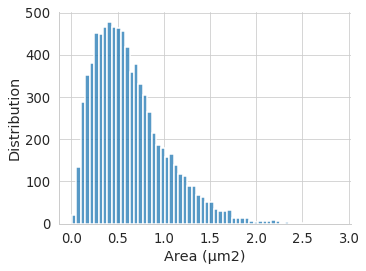

In [4]:


importlib.reload(my_plot); my_plot.my_displot(
    mpd_raw,
    x="cleft_area",
    # y="count",
    # xlim=[None, .6],
    # s=100,
    kind='hist',
    # binwidth=.0399,
    # kde=True,
    # kde_kws={'bw_adjust': 3.5},
    context='paper',
    height=4,
    y_axis_label='Distribution',
    x_axis_label='Area (µm2)',
    show=True,
    save_filename=f'{script_n}_hist.svg',
    )



Height: 4, Aspect: 1.33


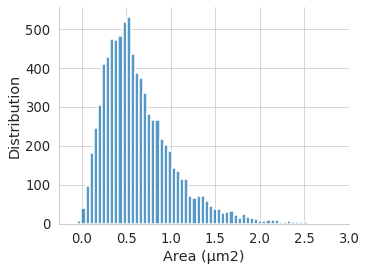

In [15]:
# fit lognormal
from scipy.stats import lognorm

s, loc, scale = lognorm.fit(raw_data)

r = lognorm.rvs(s, loc=loc, scale=scale, size=len(raw_data))

mpd_fit = MyPlotData()
for v in r:
    mpd_fit.add_data_point(
        cleft_area=v,
        type='Fit')

importlib.reload(my_plot); my_plot.my_displot(
    mpd_fit,
    x="cleft_area",
    # y="count",
    xlim=[None, 3],
    # s=100,
    kind='hist',
    # binwidth=.0399,
    # kde=True,
    # kde_kws={'bw_adjust': 3.5},
    context='paper',
    height=4,
    y_axis_label='Distribution',
    x_axis_label='Area (µm2)',
    show=True,
    save_filename=f'{script_n}_hist_fit2.svg',
    )

In [11]:
mpd_all = MyPlotData()
mpd_all.append(mpd_raw)
mpd_all.append(mpd_fit)
importlib.reload(my_plot); my_plot.my_displot(
    mpd_all,
    x="cleft_area",
    # y="count",
    xlim=[None, 50],
    # xlim=[-1.5, None],
    # s=100,
    hue='type',
    kind='hist',
    discrete=True,
    # log_scale_x=True,
    # binwidth=.0399,
    # kde=True,
    # kde_kws={'bw_adjust': 3.5},
    stat='probability',
    context='paper',
    height=4,
    aspect=1,
    y_axis_label='Frequency',
    x_axis_label='Synapses per Connection',
    show=True,
    save_filename=f'{script_n}_hist_fit.svg',
    )
print(f'n={len(mpd_raw.data)} connections')

array([0.86921802, 0.54495736, 0.71947258, ..., 0.60779678, 0.39456718,
       1.03940138])